In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import h5py
import numpy as np
from tqdm import tqdm

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from preprocessing.step_size import decay_elec_lifetime, decay_phot_lifetime, decay_phot_log10m_s, decay_elec_log10m_s
from dm21cm.utils import load_h5_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

# Injection strength

In [2]:
from dm21cm.injections.dm import DMDecayInjection
from dm21cm.injections.pbh import PBHAccretionInjection

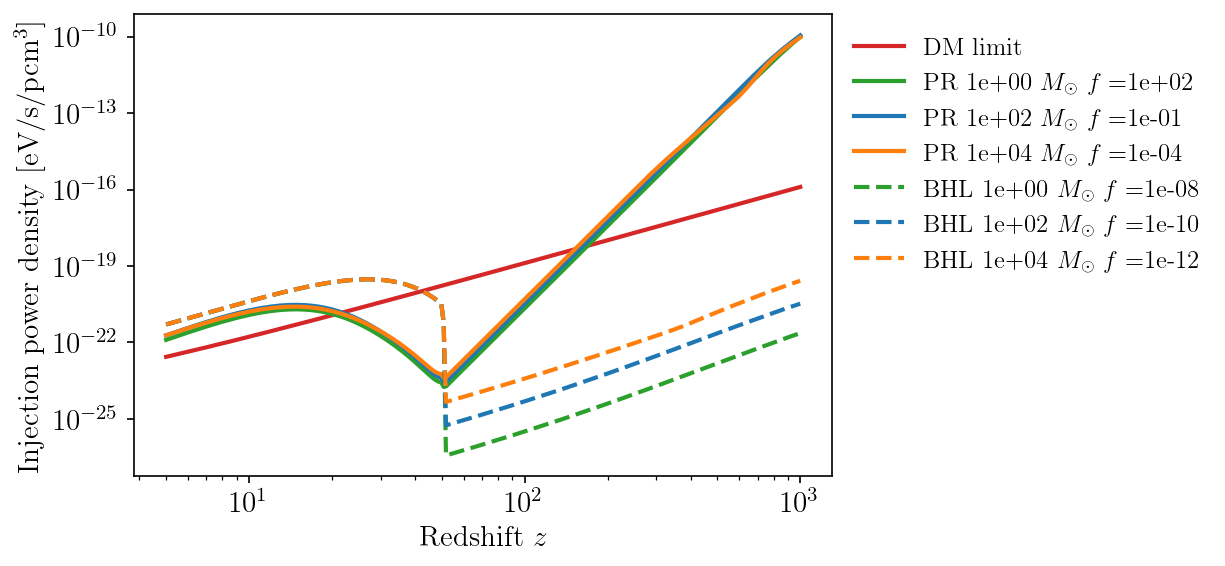

In [3]:
z_s = np.linspace(5, 1000, 1000)

m_DM = 1e5 # [eV]
tau = 1e28 # [s]
dm_inj = DMDecayInjection(primary='phot_delta', m_DM=m_DM, lifetime=tau)
dm_inj_power = np.array([dm_inj.inj_power(z) for z in z_s])

plt.plot(z_s, dm_inj_power, label='DM limit')

for m_PBH, f_PBH in zip([1, 100, 10000], [1e2, 1e-1, 1e-4]):
    pbh_inj = PBHAccretionInjection(model='PRc23', m_PBH=m_PBH, f_PBH=f_PBH)
    pbh_inj_power = np.array([pbh_inj.inj_power_std(z) for z in z_s])
    plt.plot(z_s, pbh_inj_power, label=fr'PR {m_PBH:.0e} $M_\odot$ $f=${f_PBH:.0e}')

for i, (m_PBH, f_PBH) in enumerate(zip([1, 100, 10000], [1e-8, 1e-10, 1e-12])):
    pbh_inj = PBHAccretionInjection(model='BHLl1e-02', m_PBH=m_PBH, f_PBH=f_PBH)
    pbh_inj_power = np.array([pbh_inj.inj_power_std(z) for z in z_s])
    plt.plot(z_s, pbh_inj_power, '--', color=f'C{i+1}', label=fr'BHL {m_PBH:.0e} $M_\odot$ $f=${f_PBH:.0e}')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Injection power density [eV/s/pcm$^3$]')
plt.loglog()
plt.legend(frameon=False, bbox_to_anchor=(1, 1))

# Global signal

In [9]:
outputs_dir = '/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs'

In [ ]:
bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
with h5py.File(bkg_fn, 'r') as hf:
    t21_bkg = hf['global_quantities']['brightness_temp'][()]
    z_s = hf['node_redshifts'][()]

t21_fid_s = []
t21_hom_s = []
for lm in tqdm(decay_phot_log10m_s):
    fid_fn = f"{outputs_dir}/decay/phot/log10m{lm:.1f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
    hom_fn = f"{outputs_dir}/decay/phot/log10m{lm:.1f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
    with h5py.File(fid_fn, 'r') as hf:
        t21_fid_s.append(hf['global_quantities']['brightness_temp'][()])
    with h5py.File(hom_fn, 'r') as hf:
        t21_hom_s.append(hf['global_quantities']['brightness_temp'][()])

100%|██████████| 22/22 [00:02<00:00,  7.51it/s]


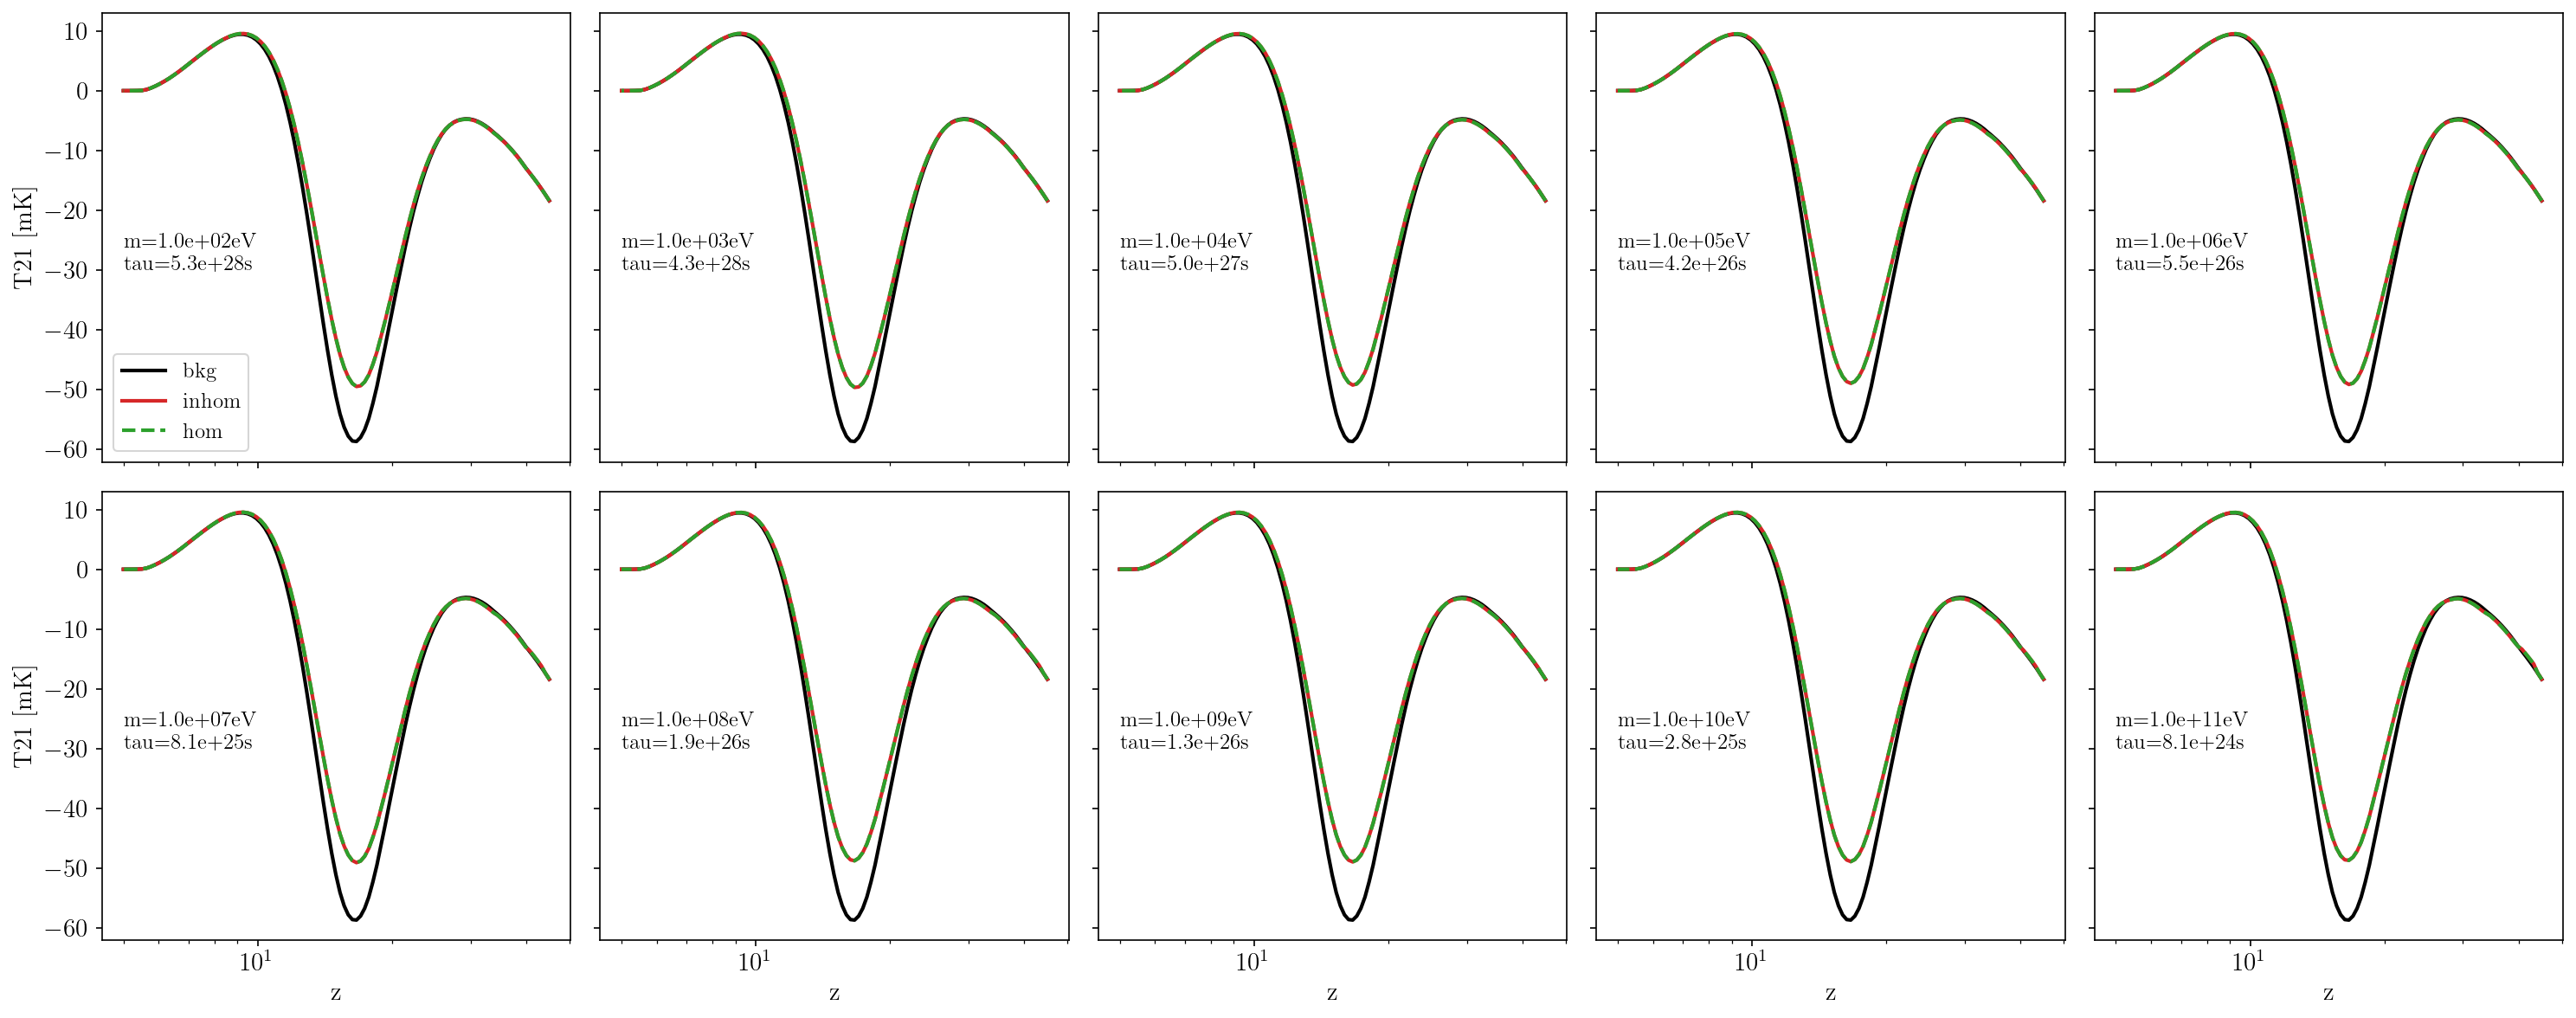

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)

for iax, ax in enumerate(axs.flat):
    i = 1 + iax * 2
    ax.plot(z_s, t21_bkg, color='k', label='bkg')
    m = 10 / np.max(np.abs(t21_fid_s[i] - t21_bkg))
    s = (t21_fid_s[i] - t21_bkg) * m + t21_bkg
    ax.plot(z_s, s, label='inhom')
    s = (t21_hom_s[i] - t21_bkg) * m + t21_bkg
    ax.plot(z_s, s, '--', label='hom')
    lm = decay_phot_log10m_s[i]
    tau = decay_phot_lifetime(10**lm) / m
    ax.text(5, -30, f'm={10**lm:.1e}eV \ntau={tau:.1e}s', fontsize=12)

for ax in axs[-1, :]:
    ax.set(xscale='log')
    ax.set(xlabel='z')

for ax in axs[:, 0]:
    ax.set(ylabel='T21 [mK]')

axs[0, 0].legend()

fig.tight_layout()

In [41]:
bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
with h5py.File(bkg_fn, 'r') as hf:
    t21_bkg = hf['global_quantities']['brightness_temp'][()]
    z_s = hf['node_redshifts'][()]

t21_fid_s = []
t21_hom_s = []
for lm in tqdm(decay_elec_log10m_s):
    fid_fn = f"{outputs_dir}/decay/elec/log10m{lm:.2f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
    hom_fn = f"{outputs_dir}/decay/elec/log10m{lm:.2f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
    with h5py.File(fid_fn, 'r') as hf:
        t21_fid_s.append(hf['global_quantities']['brightness_temp'][()])
    with h5py.File(hom_fn, 'r') as hf:
        t21_hom_s.append(hf['global_quantities']['brightness_temp'][()])

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 41.49it/s]


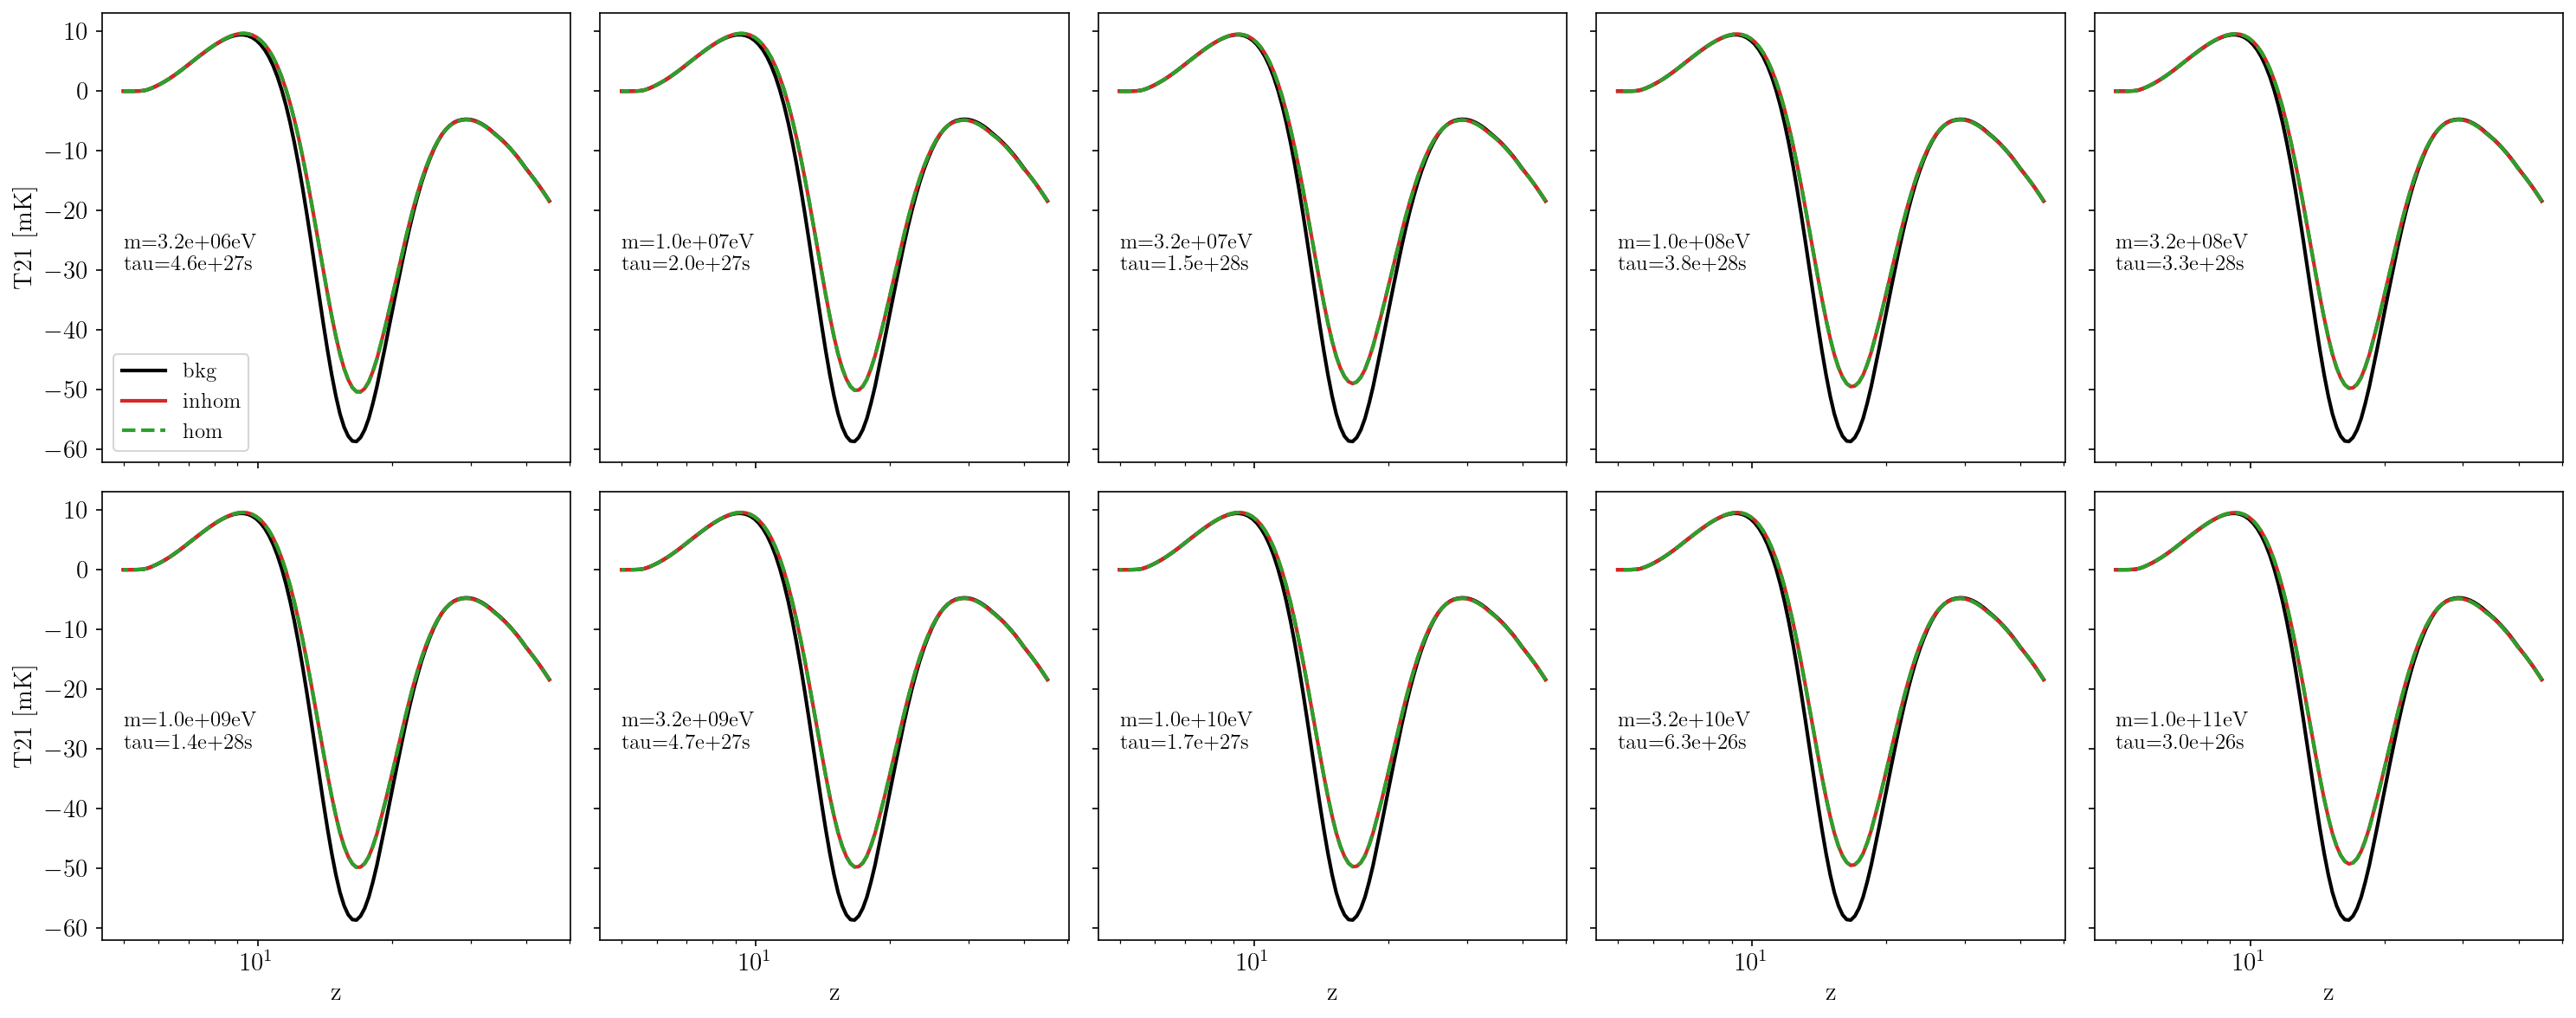

In [46]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)

for iax, ax in enumerate(axs.flat):
    i = iax * 2
    ax.plot(z_s, t21_bkg, color='k', label='bkg')
    m = 10 / np.max(np.abs(t21_fid_s[i] - t21_bkg))
    s = (t21_fid_s[i] - t21_bkg) * m + t21_bkg
    ax.plot(z_s, s, label='inhom')
    s = (t21_hom_s[i] - t21_bkg) * m + t21_bkg
    ax.plot(z_s, s, '--', label='hom')
    lm = decay_elec_log10m_s[i]
    tau = decay_elec_lifetime(10**lm) / m
    ax.text(5, -30, f'm={10**lm:.1e}eV \ntau={tau:.1e}s', fontsize=12)

for ax in axs[-1, :]:
    ax.set(xscale='log')
    ax.set(xlabel='z')

for ax in axs[:, 0]:
    ax.set(ylabel='T21 [mK]')

axs[0, 0].legend()

fig.tight_layout()

# Organize files

In [ ]:
base_dir = f"{outputs_dir}/decay/elec_hom"
for i, lm in enumerate(np.linspace(6.5, 12, 23)):
    cmd = f'mv {base_dir}/log10m{lm:.2f}/LightCones/* {base_dir}/log10m{lm:.2f}/ && rmdir {base_dir}/log10m{lm:.2f}/LightCones'
    print(cmd)
    os.system(cmd)